## Task 4


### Required libraries


In [1]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
import math


### Load the images

In [2]:
# 4 images of road lanes
image_dir = "ex4-images"

img = cv.imread(os.path.join(image_dir, 'lane1.jpg'))
img2 = cv.imread(os.path.join(image_dir, 'lane2.png'))
img3 = cv.imread(os.path.join(image_dir, 'lane3.jpg'))
img4 = cv.imread(os.path.join(image_dir, 'lane4.png'))

# Store in 2 lists
original_imgs = [img, img2, img3, img4]
copy_imgs = [img.copy(), img2.copy(), img3.copy(), img4.copy()]


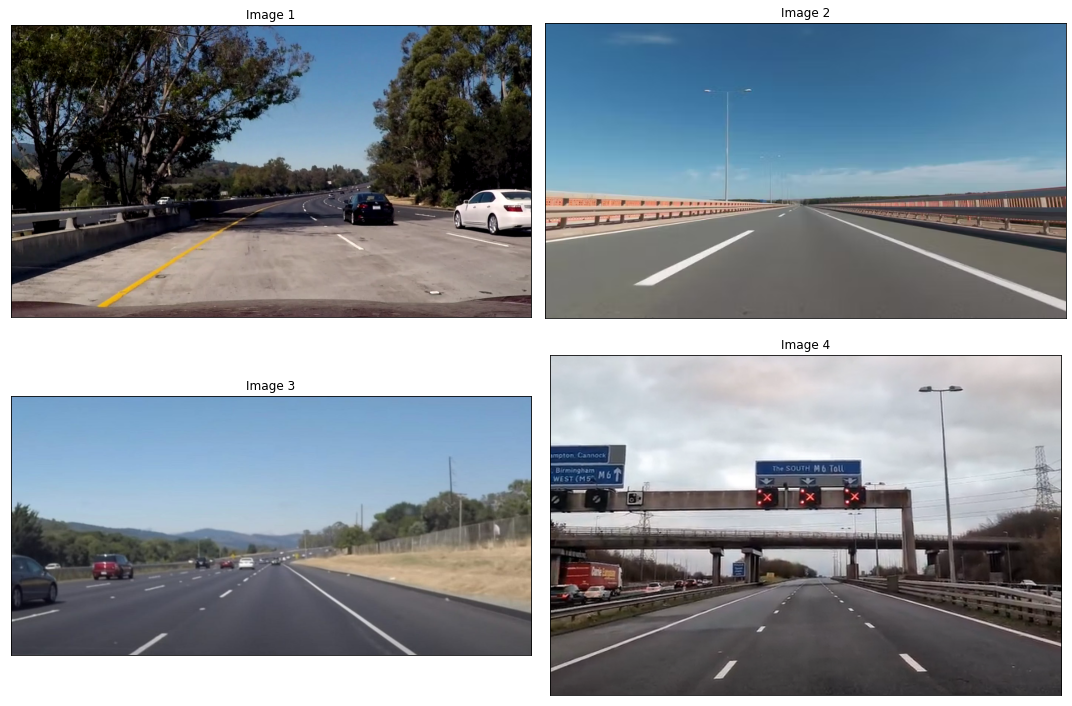

In [3]:
def display_imgs(images, cmap=None):
    # convert to rgb to display with matplotlib
    if cmap == 'bgr':
        images = [cv.cvtColor(img, cv.COLOR_BGR2RGB) for img in images]
        cmap = None

    # create figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    i = 0
    # display images
    for ax, img in zip(axs.flat, images):
        ax.imshow(img, cmap=cmap)
        ax.set_title(f'Image {i+1}')
        ax.set_xticks([])
        ax.set_yticks([])
        i += 1

    fig.tight_layout()
    plt.show()


display_imgs(original_imgs, cmap='bgr')


### Apply threshold

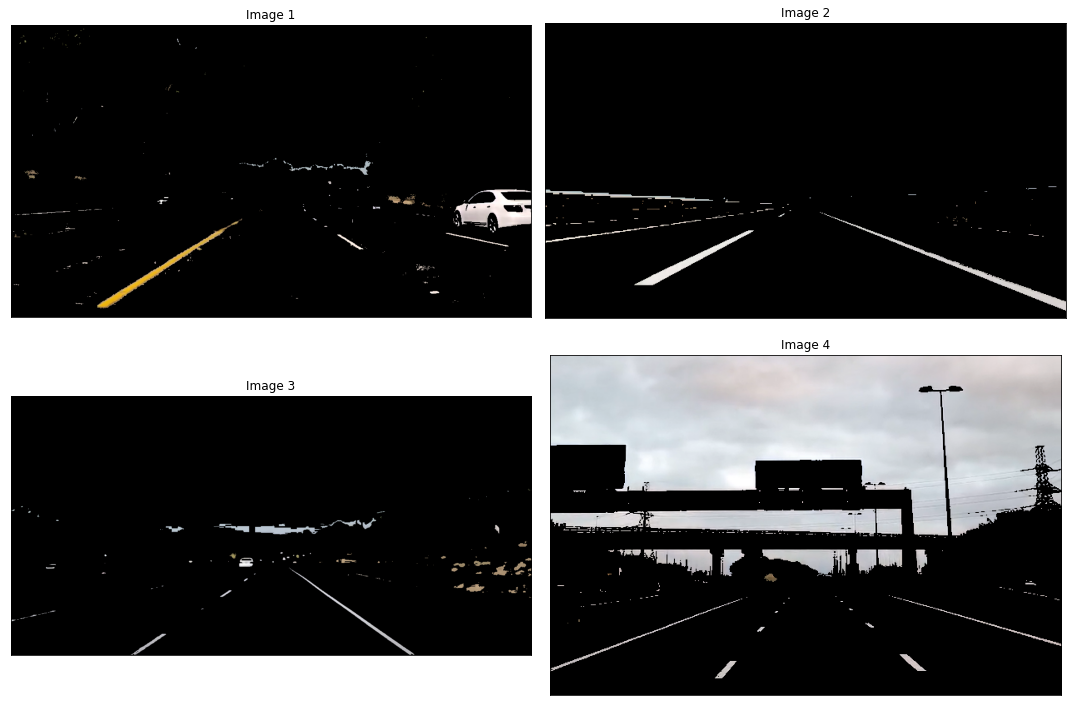

In [4]:
threshold_imgs = []


def apply_threshold(images):
    # For HSV, hue range is [0,179], saturation range is [0,255], and value range is [0,255] according to openCV docs

    # define range of 'whites' to be detected
    lower_white = np.array([0, 0, 180])  # ~[0,0,75]
    upper_white = np.array([179, 30, 255])  # ~[360,10,100]

    # define range of 'yellows' to be detected
    lower_yellow = np.array([15, 80, 100])  # ~[30,31,40]
    upper_yellow = np.array([45, 255, 255])  # ~[90,100,100]

    for x in images:

        # Convert BGR to HSV
        hsv = cv.cvtColor(x, cv.COLOR_BGR2HSV)

        # Threshold the HSV image to get only white colors
        mask_white = cv.inRange(hsv, lower_white, upper_white)

        # Threshold the HSV image to get only yellow colors
        mask_yellow = cv.inRange(hsv, lower_yellow, upper_yellow)

        # Combine the mask
        mask = cv.bitwise_or(mask_white, mask_yellow)

        # Apply the mask
        res = cv.bitwise_and(x, x, mask=mask)

        threshold_imgs.append(res)


apply_threshold(original_imgs)
display_imgs(threshold_imgs, cmap='bgr')


### Edge detection using Canny

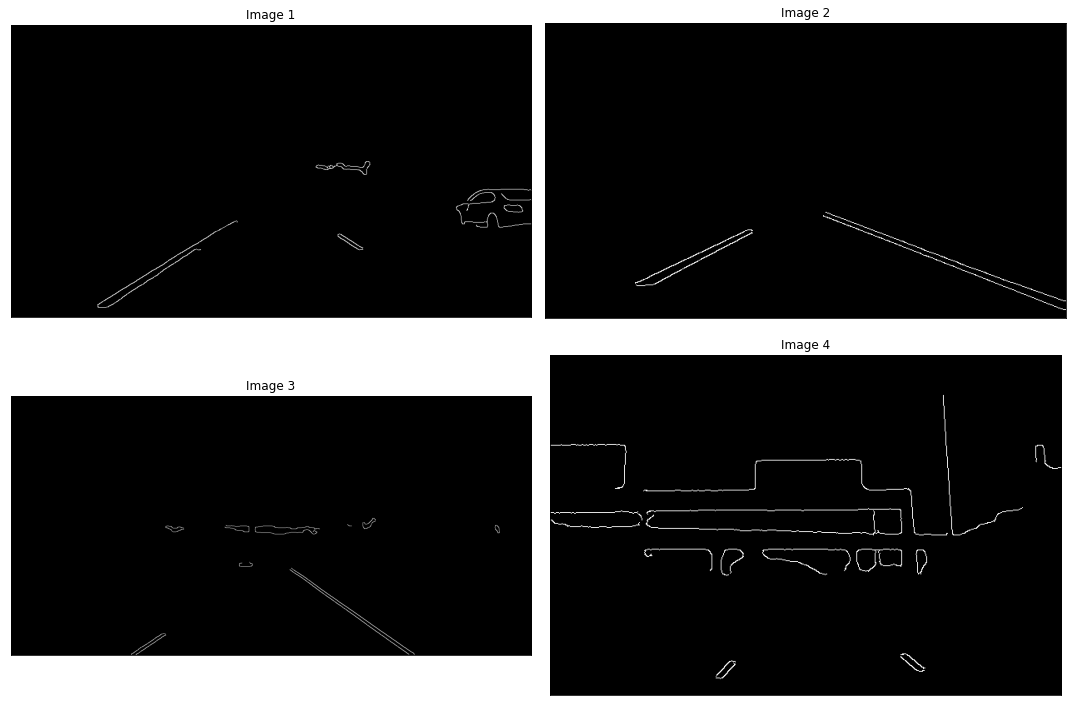

In [5]:
canny_imgs = []


def detect_edges(images):
    for x in images:
        # Convert to grayscale
        gray = cv.cvtColor(x, cv.COLOR_BGR2GRAY)

        # Apply Gaussian blur
        blur = cv.GaussianBlur(gray, (15, 15), 0)

        # Apply Canny edge detection
        edges = cv.Canny(blur, 50, 300)

        canny_imgs.append(edges)


detect_edges(threshold_imgs)
display_imgs(canny_imgs, cmap='gray')


### Region of interest

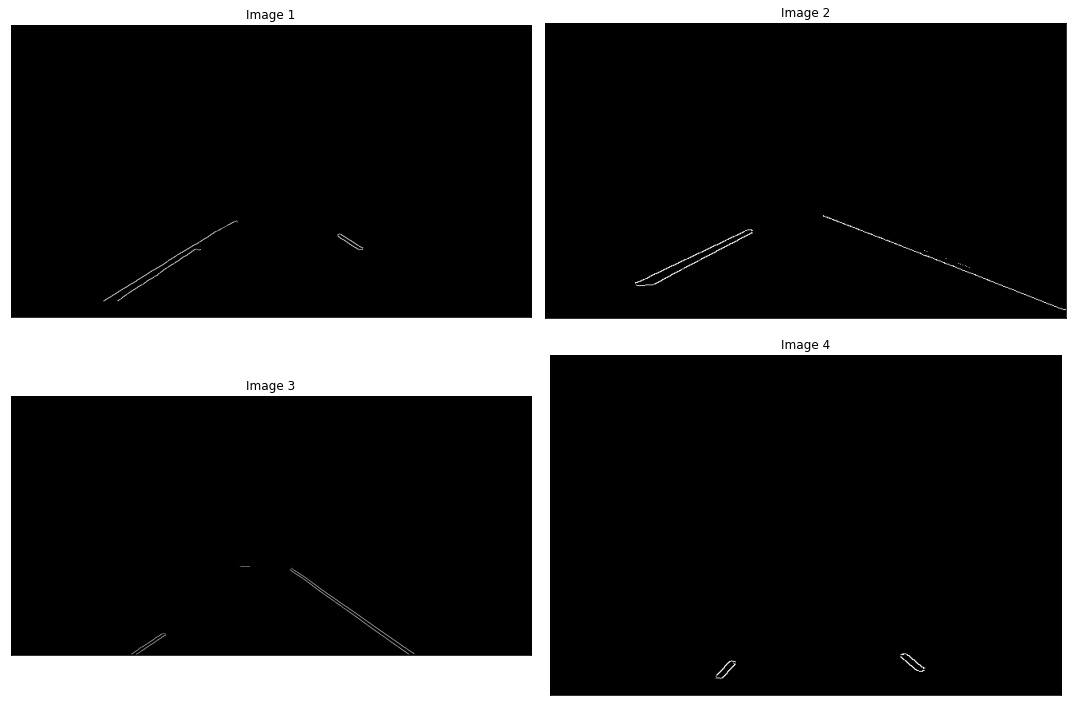

In [6]:
imgs_after_roi = []

# define the polygon by vertices
rois = [
np.array([[(0, 507), (450, 330), (650, 330), (950, 511)]], dtype=np.int32),     # roi of image 1
np.array([[(0, 370), (290, 235), (340, 235), (700, 370)]], dtype=np.int32),     # roi of image 2
np.array([[(0, 695), (600, 460), (752, 460), (1400, 695)]], dtype=np.int32),    # roi of image 3
np.array([[(0, 405), (290, 275), (340, 275), (610, 405)]], dtype=np.int32)      # roi of image 4
]
for canny_img, roi in zip(canny_imgs, rois):
    # create a mask using the polygon
    mask = np.zeros_like(canny_img)
    cv.fillPoly(mask, roi, 255)

    # apply the mask to the canny edge detected image
    img_roi = cv.bitwise_and(canny_img, mask)

    imgs_after_roi.append(img_roi)

# display the images with the mask on them
display_imgs(imgs_after_roi, cmap='gray')


### Apply Hough Transform to detect lines

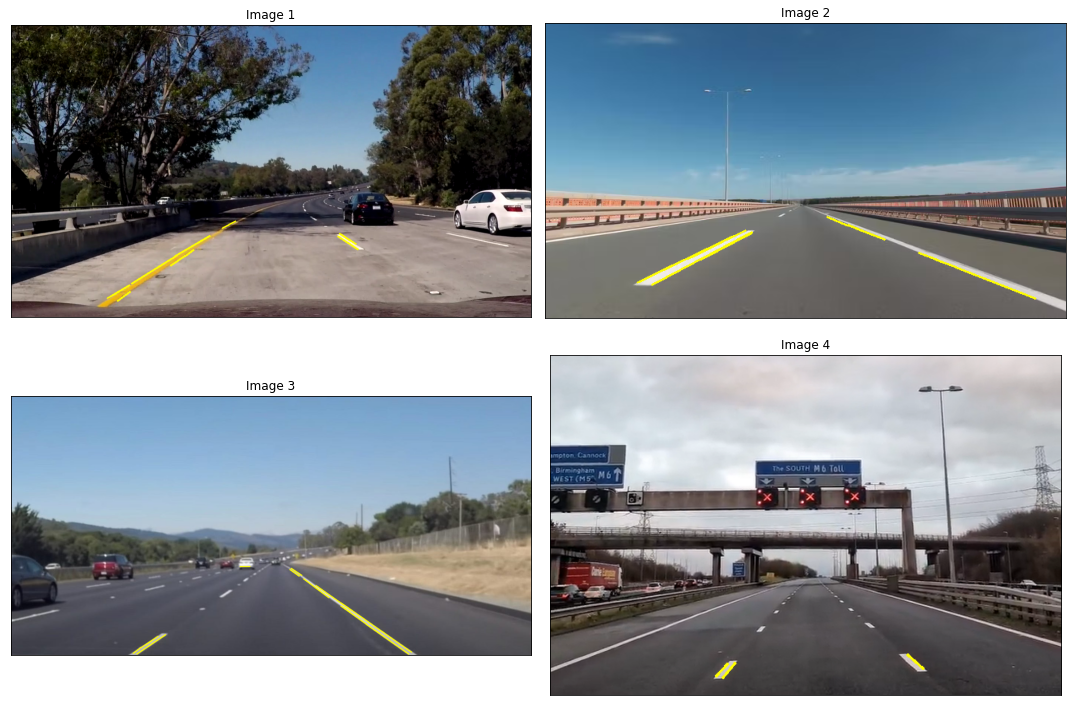

In [7]:
imgs_lines = []

# Apply Hough transform on the image
for x in imgs_after_roi:
    lines = cv.HoughLinesP(x, rho=1, theta=np.pi/180,
                            threshold=5, minLineLength=15, maxLineGap=1)
    imgs_lines.append(lines)

# Draw lines on the images
for i, lines in enumerate(imgs_lines):
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv.line(copy_imgs[i], (x1, y1), (x2, y2), [0, 255, 255], 2)

# Display the images with lines
display_imgs(copy_imgs, cmap='bgr')


### Fix the lines

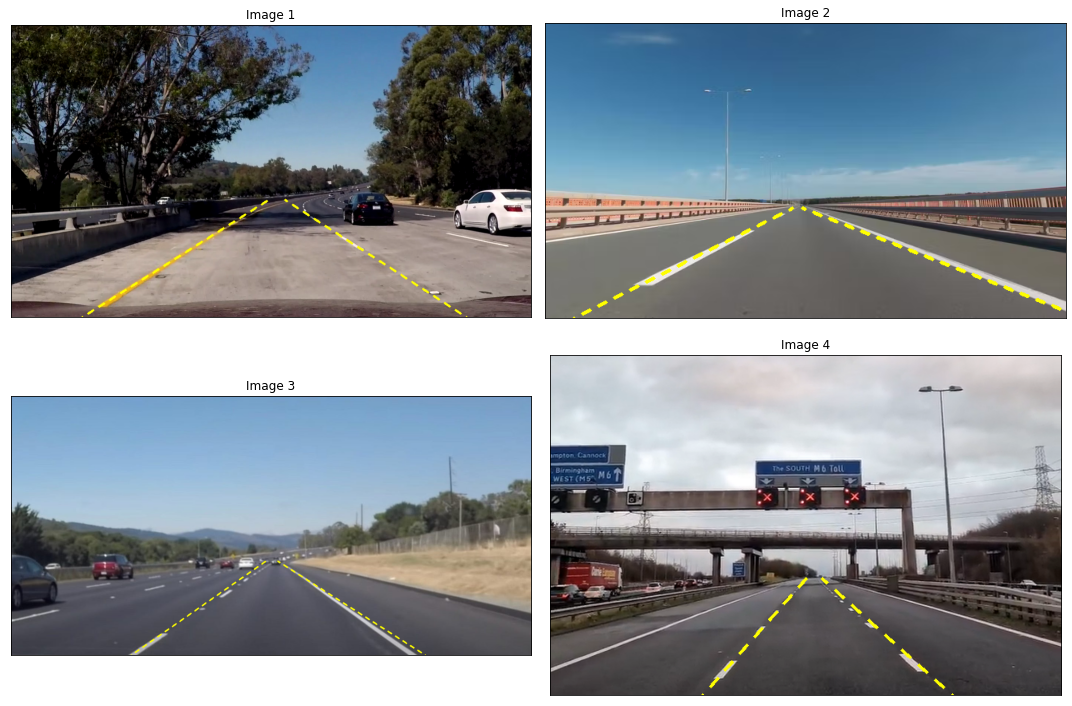

In [8]:
# Implementing Bresenham's line algorithm
def bresenham_line(x0, y0, x1, y1):
    dx, dy = abs(x1 - x0), abs(y1 - y0)
    sx, sy = 1 if x0 < x1 else -1, 1 if y0 < y1 else -1
    err = dx - dy
    points = []
    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    return points

# Draw a dotted line


def draw_dotted_line(img, x0, y0, x1, y1, color=(0, 255, 255), thickness=4, gap=10):
    points = bresenham_line(x0, y0, x1, y1)
    n_points = len(points)
    draw = True
    for i in range(n_points):
        if draw:
            cv.circle(img, points[i], thickness //
                       2, color=color, thickness=-1)
        if i % gap == 0:
            draw = not draw


# calculate the average slope and intercept of the lines
for i in range(len(original_imgs)):
    # Separate lines into left and right lanes based on slope
    left_lines = []
    right_lines = []
    for line in imgs_lines[i]:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            if slope < 0:
                left_lines.append([slope, y1 - slope * x1])
            else:
                right_lines.append([slope, y1 - slope * x1])

    # Calculate average slope and intercept for left and right lanes
    left_slope, left_intercept = np.mean(left_lines, axis=0)
    right_slope, right_intercept = np.mean(right_lines, axis=0)

    # Calculate the start and end points of the lines
    y1 = original_imgs[i].shape[0]
    if i == 0:
        y2 = int(y1 * 0.6)
    elif i == 1:
        y2 = int(y1 * 0.63)
    elif i == 2:
        y2 = int(y1 * 0.64)
    elif i == 3:
        y2 = int(y1 * 0.66)
    left_x1 = int((y1 - left_intercept) / left_slope)
    left_x2 = int((y2 - left_intercept) / left_slope)
    right_x1 = int((y1 - right_intercept) / right_slope)
    right_x2 = int((y2 - right_intercept) / right_slope)
    # Draw left and right lanes
    draw_dotted_line(original_imgs[i], left_x1, y1, left_x2, y2)
    draw_dotted_line(original_imgs[i], right_x1, y1, right_x2, y2)

display_imgs(original_imgs, cmap='bgr')


### Apply Bird Eye View

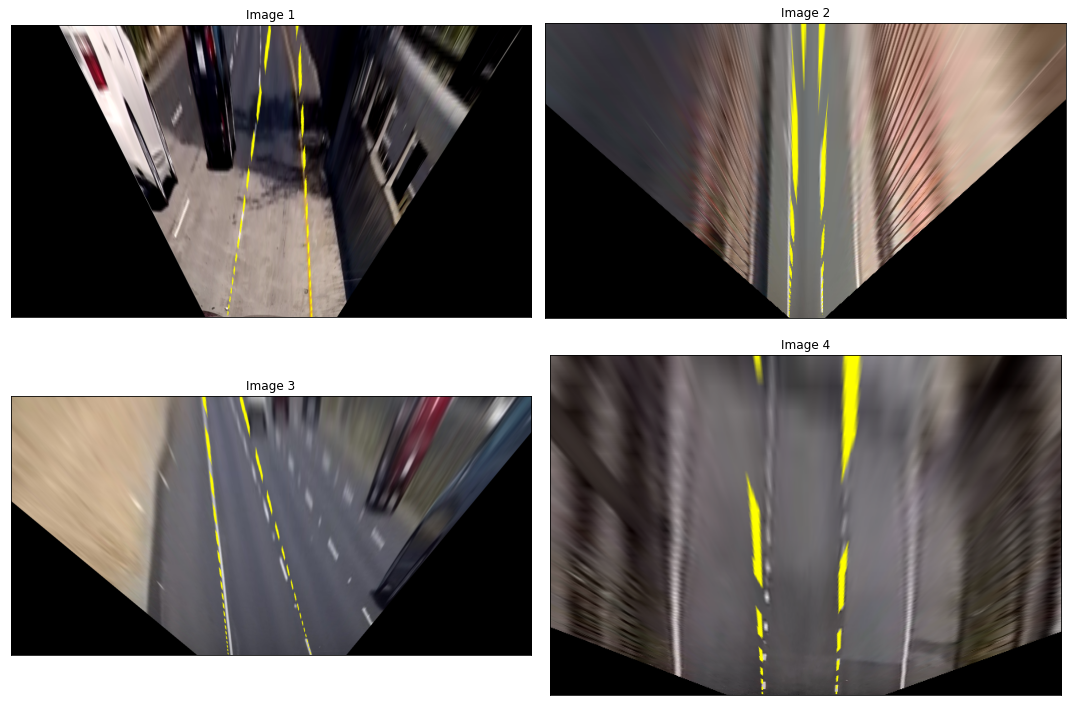

In [9]:
warped_imgs = []
imgs_lane_width = [600, 350, 900, 400]

for i, roi in enumerate(rois):
    # Define source and destination points
    src = roi.astype(np.float32)
    lane_width_px = imgs_lane_width[i]
    dst = np.float32([[lane_width_px,  original_imgs[i].shape[0]], [original_imgs[i].shape[0], 0], [
                     original_imgs[i].shape[1] - lane_width_px, 0], [original_imgs[i].shape[1]-lane_width_px, original_imgs[i].shape[0]]])

    # Compute perspective transformation matrix and apply transformation
    M = cv.getPerspectiveTransform(src, dst)
    warped = cv.warpPerspective(original_imgs[i], M, (
        original_imgs[i].shape[1], original_imgs[i].shape[0]), flags=cv.INTER_LINEAR)
    warped_imgs.append(warped)

# Display the images
display_imgs(warped_imgs, cmap='bgr')
